In [ ]:
import os
import pandas as pd
import numpy as np
import os
import re
import warnings
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
import statistics 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cv2 
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
from matplotlib.collections import EllipseCollection
from tqdm import tqdm
from scipy.stats import t
from scipy.optimize import curve_fit
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from spot_localization_functions import *
from scipy.stats import norm
from copulas.multivariate import GaussianMultivariate
from matplotlib.patches import Circle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

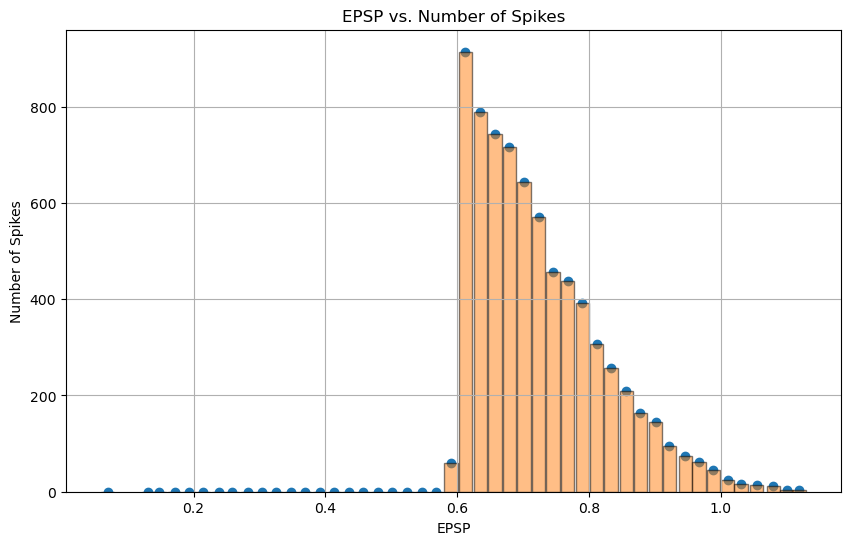

In [ ]:
# Seed for reproducibility
np.random.seed(42)

# Generate synthetic EPSP data for 4 RGCs across 100 trials
mean_epsps = np.array([0.5, 0.6, 0.4, 0.7])
std_devs = np.array([0.1, 0.12, 0.08, 0.14])
num_trials = 100
time_points = 50  # Number of time points per trial

# Generate correlated random data
cov_matrix = np.array([
    [1.0, 0.8, 0.5, 0.6],
    [0.8, 1.0, 0.4, 0.7],
    [0.5, 0.4, 1.0, 0.3],
    [0.6, 0.7, 0.3, 1.0]
])

L = np.linalg.cholesky(cov_matrix)
uncorrelated_random = np.random.normal(size=(4, time_points * num_trials))
correlated_random = L @ uncorrelated_random

epsps = mean_epsps[:, np.newaxis] + std_devs[:, np.newaxis] * correlated_random.reshape(4, -1)

epsps = epsps.reshape(4, num_trials, time_points)

threshold = 0.6
num_spikes = (epsps > threshold).sum(axis=2)

flattened_epsps = epsps.flatten()
flattened_spikes = (flattened_epsps > threshold).astype(int)

bins = np.linspace(np.min(flattened_epsps), np.max(flattened_epsps), 50)

digitized = np.digitize(flattened_epsps, bins)

spike_counts = np.array([flattened_spikes[digitized == i].sum() for i in range(1, len(bins))])

mean_epsps_per_bin = np.array([flattened_epsps[digitized == i].mean() for i in range(1, len(bins))])


# Plot EPSP vs. Count
plt.figure(figsize=(10, 6))
plt.scatter(mean_epsps_per_bin, spike_counts)
plt.bar(mean_epsps_per_bin, spike_counts, width=0.02, alpha = 0.5, edgecolor='black', align='center')
plt.xlabel('EPSP')
plt.ylabel('Number of Spikes')
plt.title('EPSP vs. Number of Spikes')
plt.grid(True)
plt.show()


[0.06965102 0.13105713 0.14819453 0.17148098 0.19302068 0.2146376
 0.23786439 0.25898    0.28180533 0.3033357  0.32518548 0.34717327
 0.36889678 0.39153281 0.41356731 0.43569218 0.45751721 0.47981943
 0.50170122 0.52430323 0.54640168 0.5680413  0.59056218 0.61257346
 0.63516455 0.65729104 0.6790815  0.70150501 0.723543   0.74527455
 0.76771616 0.78987015 0.8118397  0.83351254 0.85675151 0.87815164
 0.90106138 0.92217779 0.94605102 0.96697464 0.98874645 1.01074661
 1.03080424 1.05446242 1.07969665 1.10031683 1.11886089]
[5.932219240342164, 31.692021288277687, 34.17225653281907, 62.947846014112976, 10.858646246818958, 2.1909953070836443, 8.574543165358639, 2.0003601254169916, 16.398209075772282, 27.13912040925485, -2.6685197614347835, 4.48603606723371, 29.832843759551704, -11.162885173932636, 7.00598605416889, 18.627603966057357, 41.46583505096224, -0.40864054010494455, 0.2779969820047755, -22.106917081592, 15.260307720151435, 52.83955529912058, 87.42005508202092, 928.4303838072293, 766.

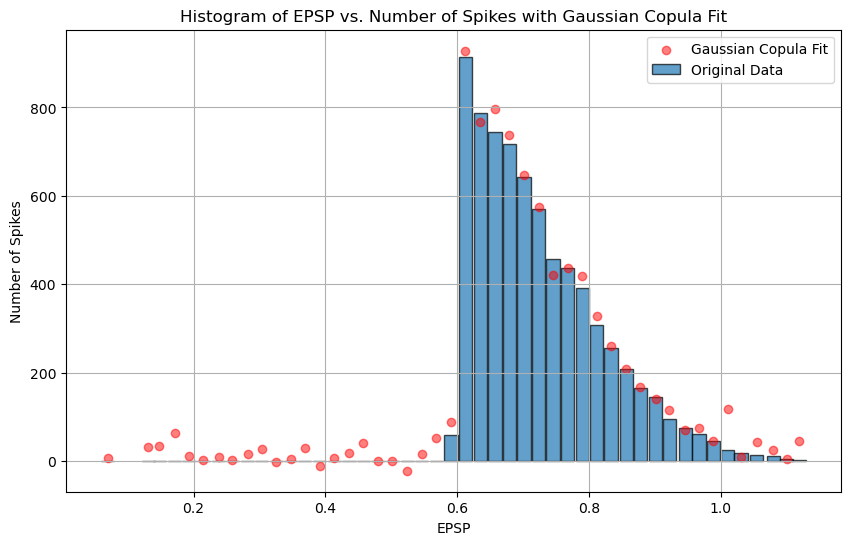

In [45]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

mean_epsps = np.array([0.5, 0.6, 0.4, 0.7])
std_devs = np.array([0.1, 0.12, 0.08, 0.14])
num_trials = 100
time_points = 50  

cov_matrix = np.array([
    [1.0, 0.8, 0.5, 0.6],
    [0.8, 1.0, 0.4, 0.7],
    [0.5, 0.4, 1.0, 0.3],
    [0.6, 0.7, 0.3, 1.0]
])

L = np.linalg.cholesky(cov_matrix)
uncorrelated_random = np.random.normal(size=(4, time_points * num_trials))
correlated_random = L @ uncorrelated_random

epsps = mean_epsps[:, np.newaxis] + std_devs[:, np.newaxis] * correlated_random.reshape(4, -1)

epsps = epsps.reshape(4, num_trials, time_points)

threshold = 0.6
num_spikes = (epsps > threshold).sum(axis=2)

flattened_epsps = epsps.flatten()
flattened_spikes = (flattened_epsps > threshold).astype(int)
bins = np.linspace(np.min(flattened_epsps), np.max(flattened_epsps), 50)

digitized = np.digitize(flattened_epsps, bins)

mean_epsps_per_bin = np.array([flattened_epsps[digitized == i].mean() for i in range(1, len(bins))])

spike_counts = np.array([flattened_spikes[digitized == i].sum() for i in range(1, len(bins))])


std_devs = np.array([np.std(flattened_spikes[digitized == i].sum()) for i in range(1, len(bins))])
valid_indices = ~np.isnan(mean_epsps_per_bin) & ~np.isnan(spike_counts)
mean_epsps_per_bin = mean_epsps_per_bin[valid_indices]
spike_counts = spike_counts[valid_indices]
std_devs = std_devs[valid_indices]
copula_data = np.vstack((mean_epsps_per_bin, spike_counts)).T
copula = GaussianMultivariate()
copula.fit(copula_data)

# Generate synthetic data from the fitted copula
synthetic_uniform_data = copula.sample(len(mean_epsps_per_bin))
synthetic_data_x = mean_epsps_per_bin
synthetic_data_y = (synthetic_uniform_data[1])*synthetic_uniform_data[0]*0.1 + spike_counts
print(synthetic_data_x)
print(list(synthetic_data_y))
# Plot Histogram of EPSP vs. Number of Spikes with Gaussian Copula Fit
plt.figure(figsize=(10, 6))
plt.bar(mean_epsps_per_bin, spike_counts, width=0.02, edgecolor='black', align='center', alpha=0.7, label='Original Data')
plt.scatter(synthetic_data_x, synthetic_data_y, color='red', alpha=0.5, label='Gaussian Copula Fit')
plt.xlabel('EPSP')
plt.ylabel('Number of Spikes')
plt.title('Histogram of EPSP vs. Number of Spikes with Gaussian Copula Fit')
plt.legend()
plt.grid(True)
plt.show()


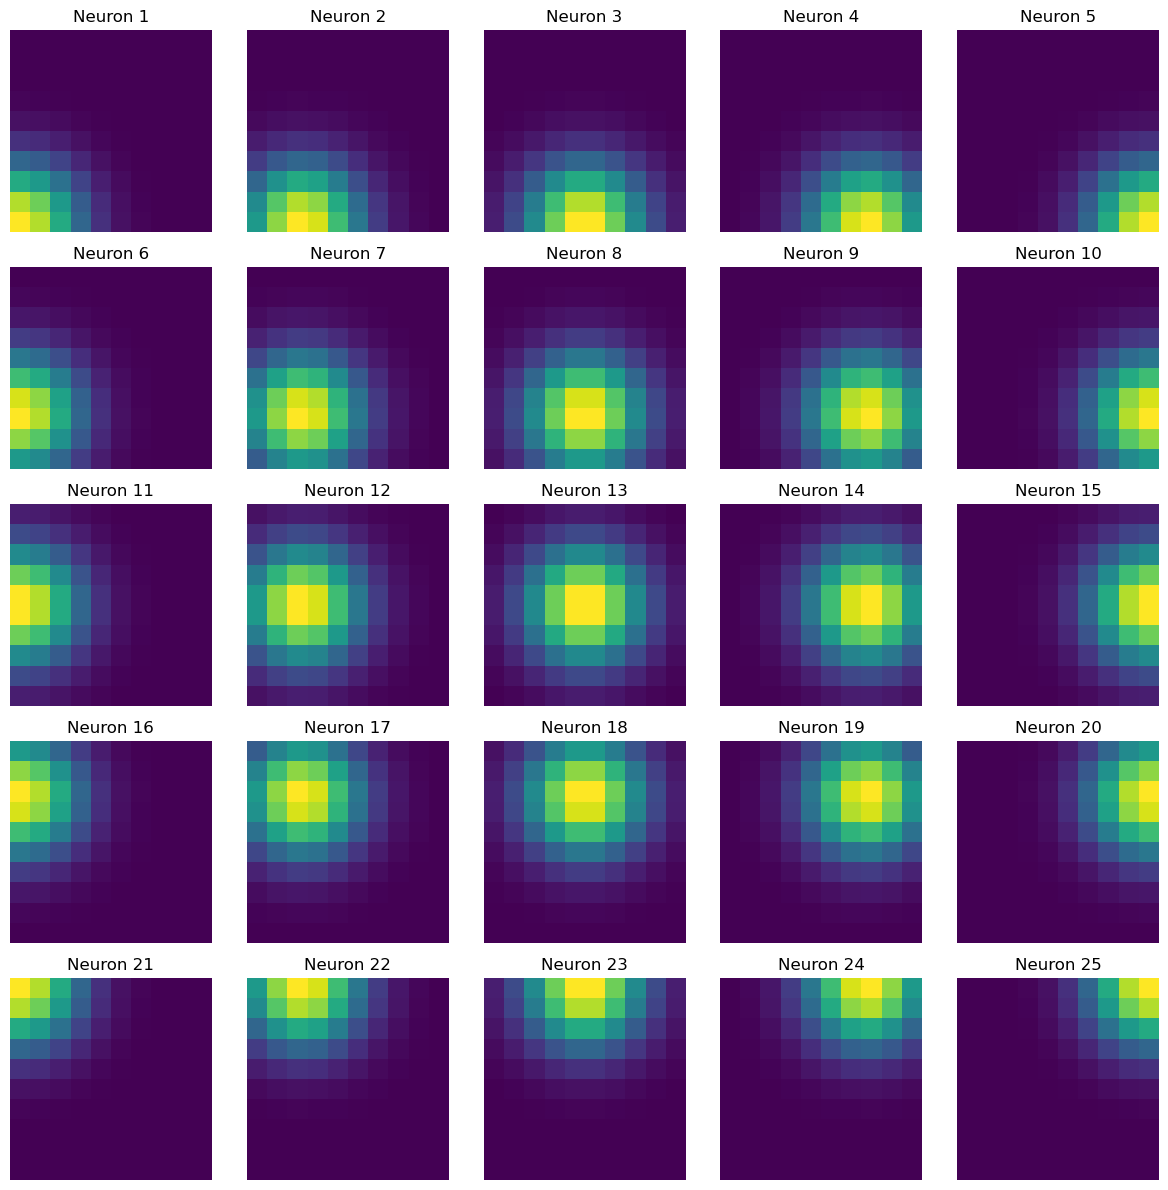

In [2]:
# Define the grid for the visual field
field_size = 10  # Assume a 10x10 grid for simplicity
x, y = np.meshgrid(np.linspace(-1, 1, field_size), np.linspace(-1, 1, field_size))

# Define the neuron locations (for simplicity, we'll use a grid)
neuron_grid_size = 5  # Assume a 5x5 grid of neurons
neuron_x, neuron_y = np.meshgrid(np.linspace(-1, 1, neuron_grid_size), np.linspace(-1, 1, neuron_grid_size))
neuron_positions = np.vstack([neuron_x.ravel(), neuron_y.ravel()]).T

# Parameters for receptive fields
sigma = 0.2  # Standard deviation for the Gaussian receptive fields

# Generate receptive fields for each neuron
receptive_fields = []
for pos in neuron_positions:
    rv = multivariate_normal(mean=pos, cov=[[sigma, 0], [0, sigma]])
    receptive_field = rv.pdf(np.dstack((x, y)))
    receptive_fields.append(receptive_field)

# Plot the receptive fields
plt.figure(figsize=(12, 12))
for i, rf in enumerate(receptive_fields):
    plt.subplot(neuron_grid_size, neuron_grid_size, i + 1)
    plt.imshow(rf, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    plt.title(f'Neuron {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
def gen_hex_grid(nx,ny, phase = 0):
    '''
    Generate a hexagonal grid of cells on [-1,1]
    '''
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,ny)
    dx = 1./(nx-1)

    X,Y = np.meshgrid(x,y)
    for y in range(phase,ny,2):
        X[y] += dx

    # want to drop every 10th spot
    #   i.e., nx*2
    X,Y = X.flatten(), Y.flatten()
    X = np.delete(X, np.arange(nx*(1+phase)-1,nx*ny, nx*2))
    Y = np.delete(Y, np.arange(nx*(1+phase)-1,nx*ny, nx*2))
    

    return X,Y

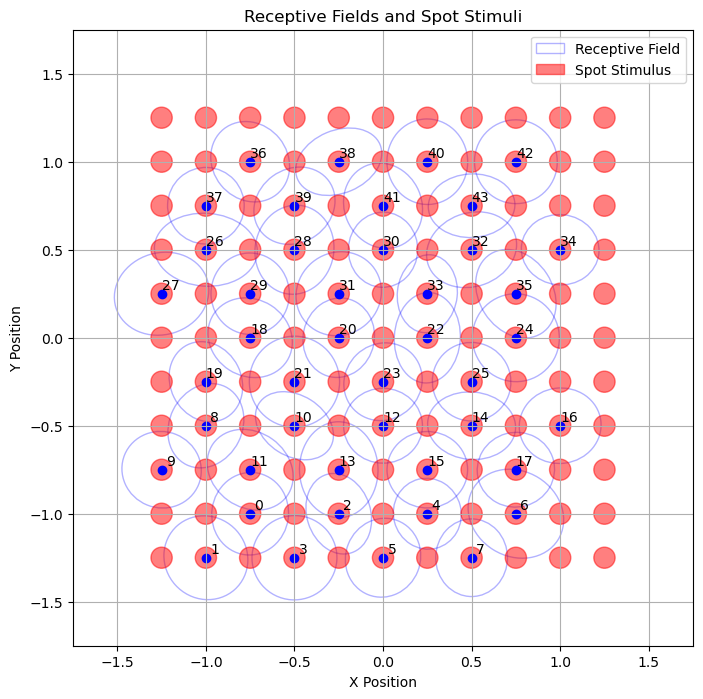

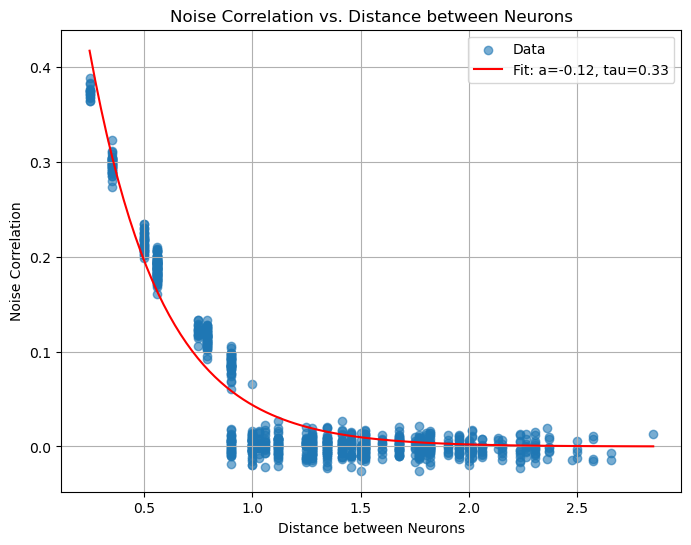

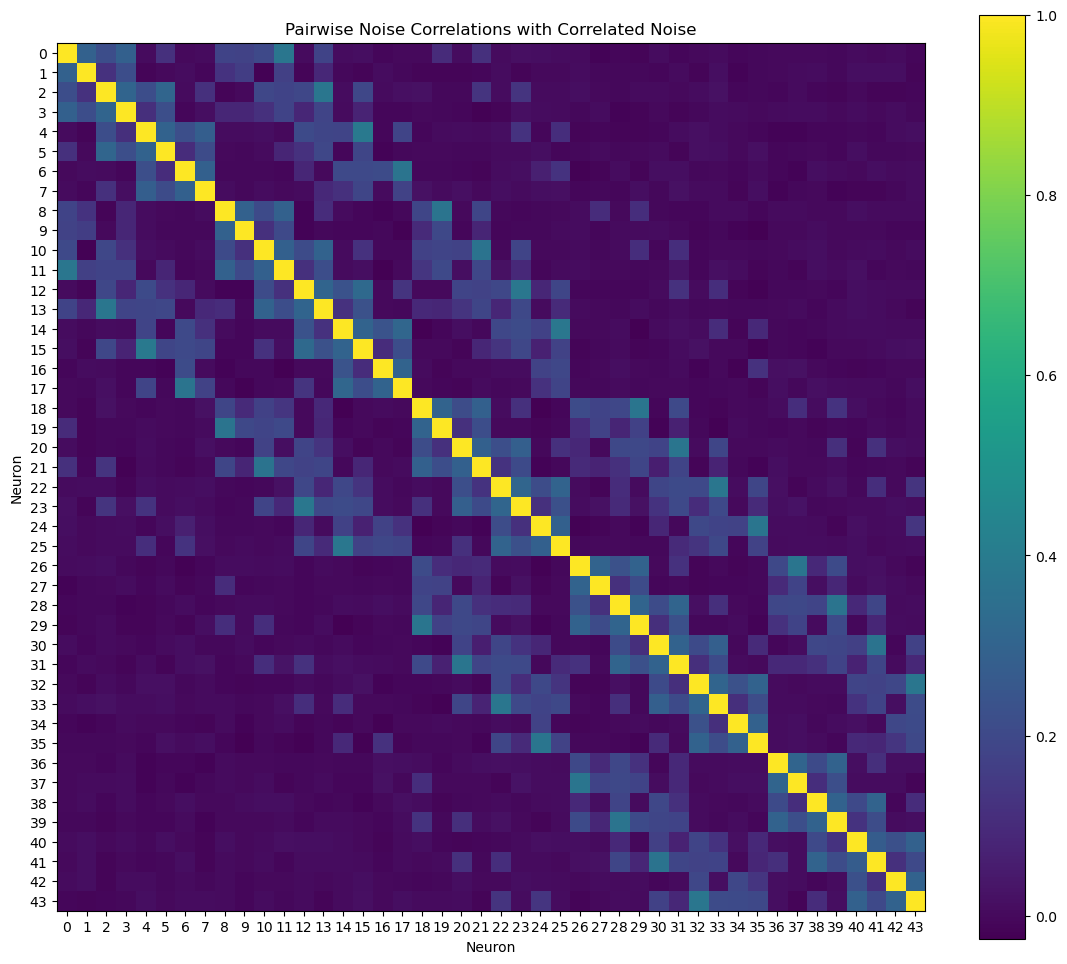

In [ ]:
def approximate_ellipse_overlap(pos1, width1, height1, pos2, width2, height2):
    dx = pos2[0] - pos1[0]
    dy = pos2[1] - pos1[1]
    d = np.sqrt(dx**2 + dy**2)
    avg_radius1 = (width1 + height1) / 2
    avg_radius2 = (width2 + height2) / 2
    if d < (avg_radius1 + avg_radius2):
        overlap_area = np.pi * min(width1, width2) * min(height1, height2) / 4
        return overlap_area
    return 0

def RFs_mosaics(field_size, sigma, s, w, spot_radius, num_trials=100):
    x, y = np.meshgrid(np.linspace(-1, 1, field_size), np.linspace(-1, 1, field_size))
    neuron_positions = []
    for i in range(0, len(gen_hex_grid(5, 5)[0])):
        neuron_positions.append([gen_hex_grid(5, 5)[0][i], gen_hex_grid(5, 5)[1][i]])
        neuron_positions.append([gen_hex_grid(5, 5)[0][i] - 0.25, gen_hex_grid(5, 5)[1][i] - 0.25])
    neuron_positions = np.array(neuron_positions)
    stim_x, stim_y = np.meshgrid(np.arange(-1.25, 1.5, 0.25), np.arange(-1.25, 1.5, 0.25))
    spot_positions = np.stack((stim_x.flatten(), stim_y.flatten()), axis=-1)
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    widths = s * np.random.randn(len(neuron_positions)) + w
    heights = s * np.random.randn(len(neuron_positions)) + w
    angles = np.random.rand(len(neuron_positions)) * 360
    for idx, (pos, width, height, angle) in enumerate(zip(neuron_positions, widths, heights, angles)):
        ellipse = Ellipse(pos, width, height, angle, edgecolor='blue', facecolor='none', alpha=0.3, label='Receptive Field' if idx == 0 else "")
        ax.add_patch(ellipse)
        plt.text(pos[0] + 0.05, pos[1] + 0.05, str(idx), color='black', ha='center', va='center')
    for spot in spot_positions:
        circle = Circle(spot, spot_radius, color='red', alpha=0.5, label='Spot Stimulus' if spot[0] == spot_positions[0][0] and spot[1] == spot_positions[0][1] else "")
        ax.add_patch(circle)
    plt.scatter(neuron_positions[:, 0], neuron_positions[:, 1], color='blue')
    plt.xlim(-1.75, 1.75)
    plt.ylim(-1.75, 1.75)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Receptive Fields and Spot Stimuli')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()
    def difference_of_gaussians(x, y, center, sigma_center, sigma_surround):
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        center_gaussian = np.exp(-dist_squared / (2 * sigma_center**2))
        surround_gaussian = np.exp(-dist_squared / (2 * sigma_surround**2))
        return center_gaussian - surround_gaussian
    n_spots = spot_positions.shape[0]
    n_neurons = len(neuron_positions)
    responses = np.zeros((num_trials, n_spots, n_neurons))
    for k in range(num_trials):
        for i, spot in enumerate(spot_positions):
            for j, neuron in enumerate(neuron_positions):
                responses[k, i, j] = difference_of_gaussians(spot[0], spot[1], neuron, sigma, sigma * 1.5)
    mean = np.zeros(n_neurons)
    return responses, num_trials, n_spots, n_neurons, mean, neuron_positions, widths, heights, angles

def noise_cov_matrix_plot(responses, num_trials, n_spots, n_neurons, mean, neuron_positions, widths, heights, angles, cov_const):
    cov = np.zeros((n_neurons, n_neurons))
    for i in range(n_neurons):
        for j in range(n_neurons):
            if i == j:
                cov[i, j] = 1
            else:
                overlap_area = approximate_ellipse_overlap(neuron_positions[i], widths[i], heights[i], neuron_positions[j], widths[j], heights[j])
                dist = np.linalg.norm(neuron_positions[i] - neuron_positions[j])
                if overlap_area > 0:
                    cov[i, j] = cov_const * np.exp(-dist / sigma)
    for k in range(num_trials):
        for i in range(n_spots):
            noise = np.random.multivariate_normal(mean, cov)
            responses[k, i, :] += noise
    mean_responses = np.mean(responses, axis=0)
    residuals = responses - mean_responses
    flat_residuals = residuals.reshape(-1, n_neurons)
    def compute_noise_correlations(residuals):
        cov_matrix = np.cov(residuals, rowvar=False)
        std_devs = np.sqrt(np.diag(cov_matrix))
        corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
        return corr_matrix, cov_matrix
    correlation_matrix, noise_cov_matrix = compute_noise_correlations(flat_residuals)
    signal_variance = np.var(mean_responses, axis=0)
    noise_variance = np.var(residuals, axis=(0, 1))
    snr = signal_variance / noise_variance
    avg_noise_covariance = np.mean(noise_cov_matrix, axis=1)
    distances = []
    noise_correlations = []
    for i in range(n_neurons):
        for j in range(i + 1, n_neurons):
            dist = np.linalg.norm(neuron_positions[i] - neuron_positions[j])
            distances.append(dist)
            noise_correlations.append(correlation_matrix[i, j])
    def exp_decay(x, a, tau):
        return np.exp(-x/tau + a)
    popt, _ = curve_fit(exp_decay, distances, noise_correlations)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(distances, noise_correlations, alpha=0.6, label='Data')
    x_fit = np.linspace(min(distances), max(distances), 100)
    y_fit = exp_decay(x_fit, *popt)
    plt.plot(x_fit, y_fit, 'r-', label=f'Fit: a={popt[0]:.2f}, tau={popt[1]:.2f}')
    plt.xlabel('Distance between Neurons')
    plt.ylabel('Noise Correlation')
    plt.title('Noise Correlation vs. Distance between Neurons')
    plt.legend()
    plt.grid(True)
    
    # Plot the correlation matrix
    plt.figure(figsize=(14, 12))
    plt.imshow(correlation_matrix, cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('Pairwise Noise Correlations with Correlated Noise')
    plt.xticks(range(n_neurons))
    plt.yticks(range(n_neurons))
    plt.xlabel('Neuron')
    plt.ylabel('Neuron')
    plt.show()
    return cov, snr, avg_noise_covariance, distances, noise_correlations

# Example usage
field_size = 10
sigma = 0.45
s = 0.05
w = 0.45
spot_radius = 0.06
num_trials = 100
responses, num_trials, n_spots, n_neurons, mean, neuron_positions, widths, heights, angles = RFs_mosaics(field_size, sigma, s, w, spot_radius, num_trials)
cov_const = 0.65
cov, snr, avg_noise_covariance, distances, noise_correlations = noise_cov_matrix_plot(responses, num_trials, n_spots, n_neurons, mean, neuron_positions, widths, heights, angles, cov_const)

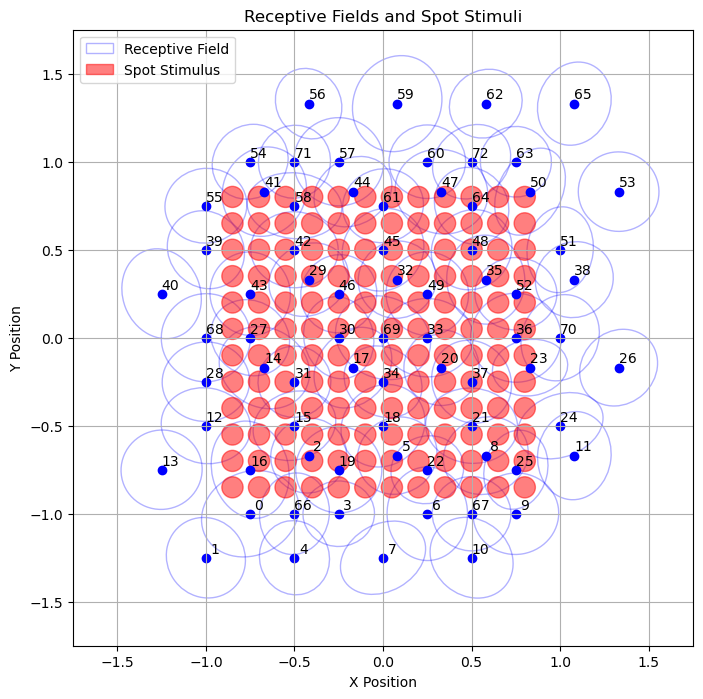

Decoding accuracy (test set): 76.06%
Cross-validated accuracy: 76.55% ± 0.68%
Decoding error (test set): 23.94%


In [ ]:
def gen_hex_grid(nx, ny, phase=0):
    x = np.linspace(-1, 1, nx)
    y = np.linspace(-1, 1, ny)
    dx = 1. / (nx - 1)
    X, Y = np.meshgrid(x, y)
    for y in range(phase, ny, 2):
        X[y] += dx
    X, Y = X.flatten(), Y.flatten()
    X = np.delete(X, np.arange(nx * (1 + phase) - 1, nx * ny, nx * 2))
    Y = np.delete(Y, np.arange(nx * (1 + phase) - 1, nx * ny, nx * 2))
    return X, Y

def approximate_ellipse_overlap(pos1, width1, height1, pos2, width2, height2):
    dx = pos2[0] - pos1[0]
    dy = pos2[1] - pos1[1]
    d = np.sqrt(dx**2 + dy**2)
    avg_radius1 = (width1 + height1) / 2
    avg_radius2 = (width2 + height2) / 2
    if d < (avg_radius1 + avg_radius2):
        overlap_area = np.pi * min(width1, width2) * min(height1, height2) / 4
        return overlap_area
    return 0

def RFs_mosaics(field_size, sigma, s, w, spot_radius):
    x, y = np.meshgrid(np.linspace(-1, 1, field_size), np.linspace(-1, 1, field_size))
    neuron_positions = []
    for i in range(0, len(gen_hex_grid(5, 5)[0])):
        neuron_positions.append([gen_hex_grid(5, 5)[0][i], gen_hex_grid(5, 5)[1][i]])
        neuron_positions.append([gen_hex_grid(5, 5)[0][i] - 0.25, gen_hex_grid(5, 5)[1][i] - 0.25])
        neuron_positions.append([gen_hex_grid(5, 5)[0][i] + 0.33, gen_hex_grid(5, 5)[1][i] + 0.33])
    for i in range(0, len(gen_hex_grid(3, 3)[0])):
        neuron_positions.append([gen_hex_grid(3, 3)[0][i], gen_hex_grid(3, 3)[1][i]])    


    neuron_positions = np.array(neuron_positions)
    stim_x, stim_y = np.meshgrid(np.arange(-0.85, 0.85, 0.15), np.arange(-0.85, 0.85, 0.15))
    spot_positions = np.stack((stim_x.flatten(), stim_y.flatten()), axis=-1)
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    widths = s * np.random.randn(len(neuron_positions)) + w
    heights = s * np.random.randn(len(neuron_positions)) + w
    angles = np.random.rand(len(neuron_positions)) * 360
    for idx, (pos, width, height, angle) in enumerate(zip(neuron_positions, widths, heights, angles)):
        ellipse = Ellipse(pos, width, height, angle, edgecolor='blue', facecolor='none', alpha=0.3, label='Receptive Field' if idx == 0 else "")
        ax.add_patch(ellipse)
        plt.text(pos[0] + 0.05, pos[1] + 0.05, str(idx), color='black', ha='center', va='center')
    for spot in spot_positions:
        circle = Circle(spot, spot_radius, color='red', alpha=0.5, label='Spot Stimulus' if spot[0] == spot_positions[0][0] and spot[1] == spot_positions[0][1] else "")
        ax.add_patch(circle)
    plt.scatter(neuron_positions[:, 0], neuron_positions[:, 1], color='blue')
    plt.xlim(-1.75, 1.75)
    plt.ylim(-1.75, 1.75)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Receptive Fields and Spot Stimuli')
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()
    return neuron_positions, widths, heights, angles, spot_positions

def simulate_spike_trains(neuron_positions, widths, heights, angles, spot_positions, sigma, spontaneous_rate=1, stim_rate=20, stim_duration=0.1, interval=0.05, num_trials=100):
    n_neurons = len(neuron_positions)
    n_spots = len(spot_positions)
    spike_trains = np.zeros((num_trials, n_spots, n_neurons))
    
    for trial in range(num_trials):
        for s_idx, spot in enumerate(spot_positions):
            for n_idx, neuron in enumerate(neuron_positions):
                overlap_area = approximate_ellipse_overlap(neuron, widths[n_idx], heights[n_idx], spot, spot_radius, spot_radius)
                if overlap_area > 0:
                    firing_rate = stim_rate
                else:
                    firing_rate = spontaneous_rate
                spike_count = np.random.poisson(firing_rate * stim_duration)
                spike_trains[trial, s_idx, n_idx] = spike_count
    return spike_trains


def estimate_decoding_accuracy(spike_trains, spot_positions, test_size=0.3, random_state=42, cv_folds=5, verbose=True):
    num_trials, n_spots, n_neurons = spike_trains.shape
    X = spike_trains.reshape(-1, n_neurons)
    y = np.tile(np.arange(n_spots), num_trials)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel="rbf", probability=True))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        stratify=y, random_state=random_state)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(pipeline, X, y, cv=cv)

    if verbose:
        print(f'Decoding accuracy (test set): {accuracy * 100:.2f}%')
        print(f'Cross-validated accuracy: {np.mean(cv_scores) * 100:.2f}% ± {np.std(cv_scores) * 100:.2f}%')
        print(f'Decoding error (test set): {(1 - accuracy) * 100:.2f}%')

    return pipeline, X_test, y_test, y_pred, accuracy, cv_scores


def draw_probability_map(clf, spot_positions, grid_size=50):
    x_min, x_max = spot_positions[:, 0].min() - 0.1, spot_positions[:, 0].max() + 0.1
    y_min, y_max = spot_positions[:, 1].min() - 0.1, spot_positions[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 100), cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(spot_positions[:, 0], spot_positions[:, 1], c='black', marker='o', edgecolor='k', s=100)
    plt.title('Probability Map of Decoded Stimulus Positions')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.colorbar()
    plt.show()

# Parameters
field_size = 10
sigma = 0.6
s = 0.05
w = 0.45
spot_radius = 0.06
spontaneous_rate = 1  # Hz
stim_rate = 20  # Hz
stim_duration = 0.1  # s
interval = 0.05  # s
num_trials = 100

# Generate RFs and stimuli positions
neuron_positions, widths, heights, angles, spot_positions = RFs_mosaics(field_size, sigma, s, w, spot_radius)

# Simulate spike trains
spike_trains = simulate_spike_trains(neuron_positions, widths, heights, angles, spot_positions, sigma, spontaneous_rate, stim_rate, stim_duration, interval, num_trials)

# Estimate decoding accuracy
pipeline, X_test, y_test, y_pred, accuracy, cv_scores = estimate_decoding_accuracy(spike_trains, spot_positions)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

def compare_classifiers(X, y, pca_components=None, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM (Linear)": SVC(kernel="linear"),
        "SVM (RBF)": SVC(kernel="rbf"),
        "Naive Bayes": GaussianNB(),
        "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
    }

    results = {}

    for name, clf in classifiers.items():
        steps = [('scaler', StandardScaler())]
        if pca_components:
            steps.append(('pca', PCA(n_components=pca_components)))
        steps.append(('clf', clf))
        
        pipe = Pipeline(steps)

        # Fit and evaluate
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cv = cross_val_score(pipe, X, y, cv=5)
        
        results[name] = {
            "test_accuracy": acc,
            "cv_accuracy_mean": cv.mean(),
            "cv_accuracy_std": cv.std()
        }

        print(f"\n=== {name} ===")
        print(f"Test accuracy: {acc * 100:.2f}%")
        print(f"Cross-validated accuracy: {cv.mean() * 100:.2f}% ± {cv.std() * 100:.2f}%")

        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(16, 14))  
        ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, include_values=False, ax=ax)
        plt.title(name)
        plt.tight_layout()
        plt.show()

    return results


=== Logistic Regression ===
Test accuracy: 71.46%
Cross-validated accuracy: 72.63% ± 0.54%


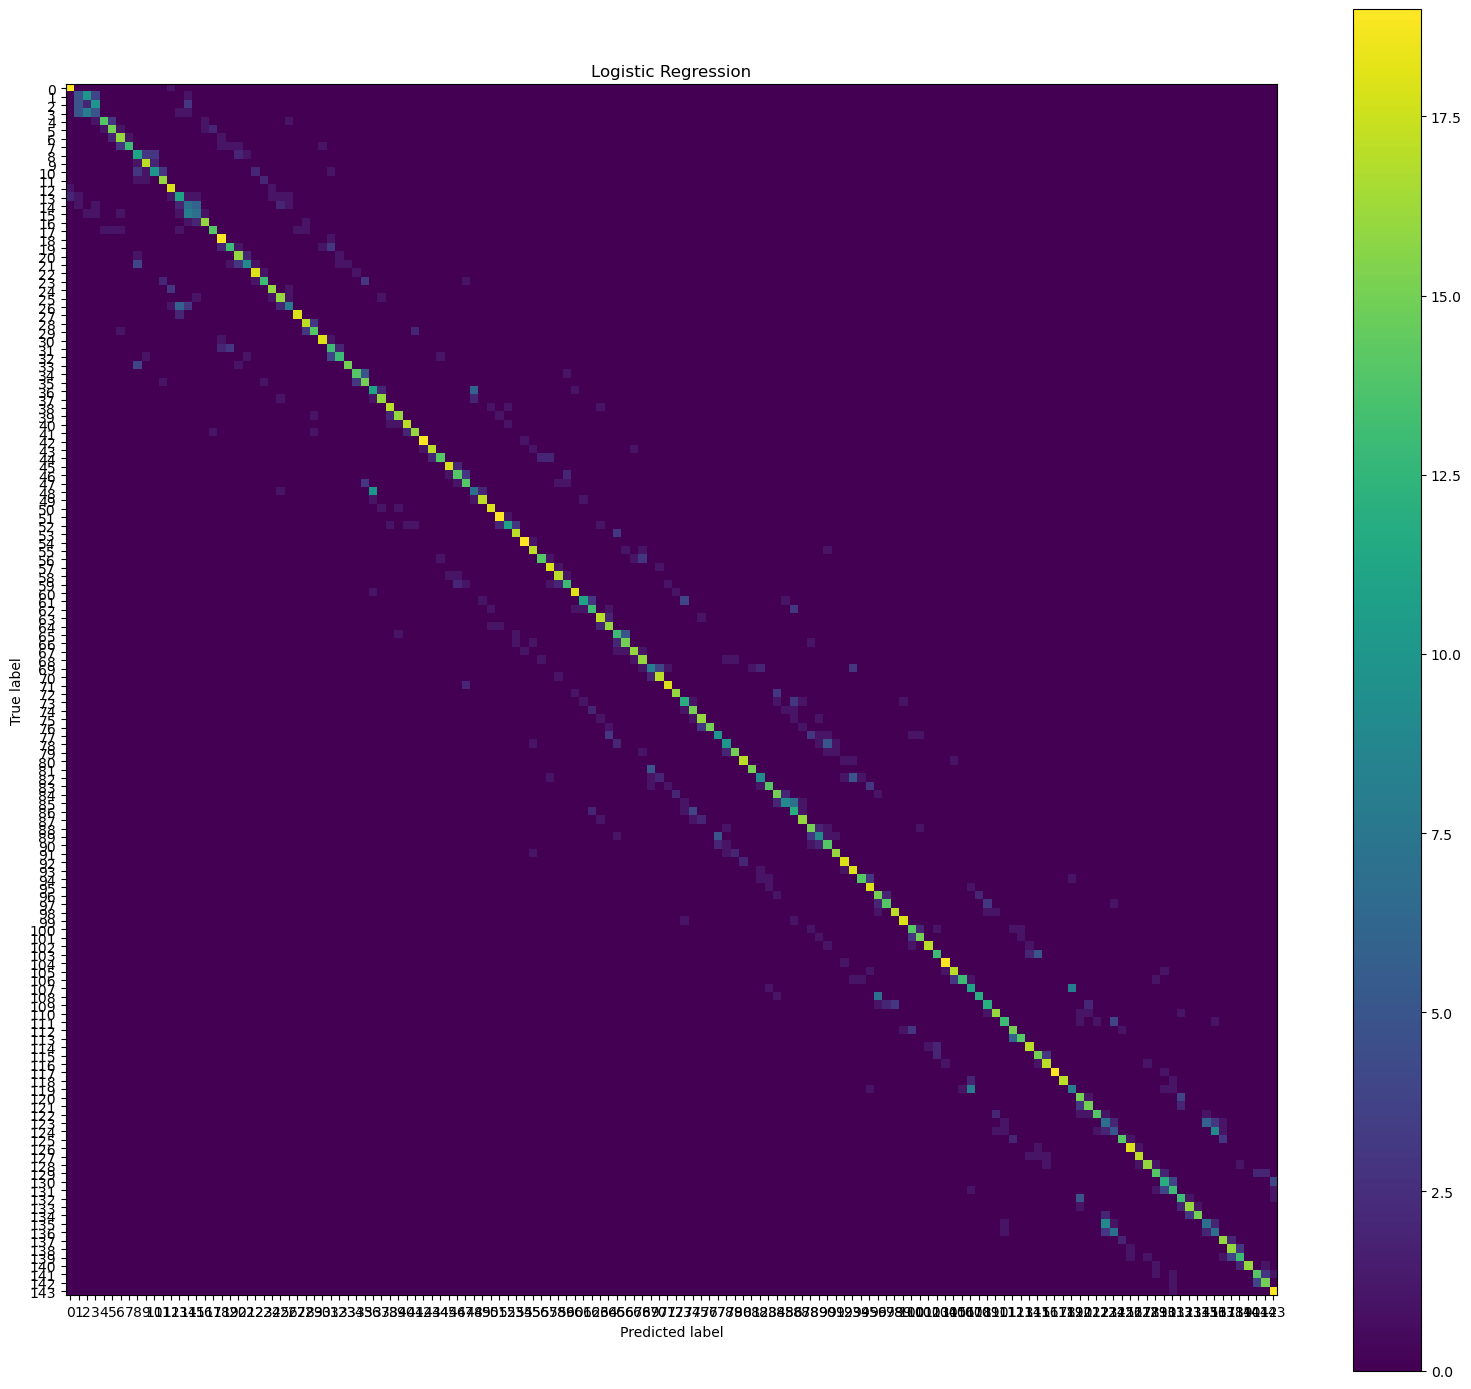


=== Random Forest ===
Test accuracy: 64.44%
Cross-validated accuracy: 64.67% ± 0.89%


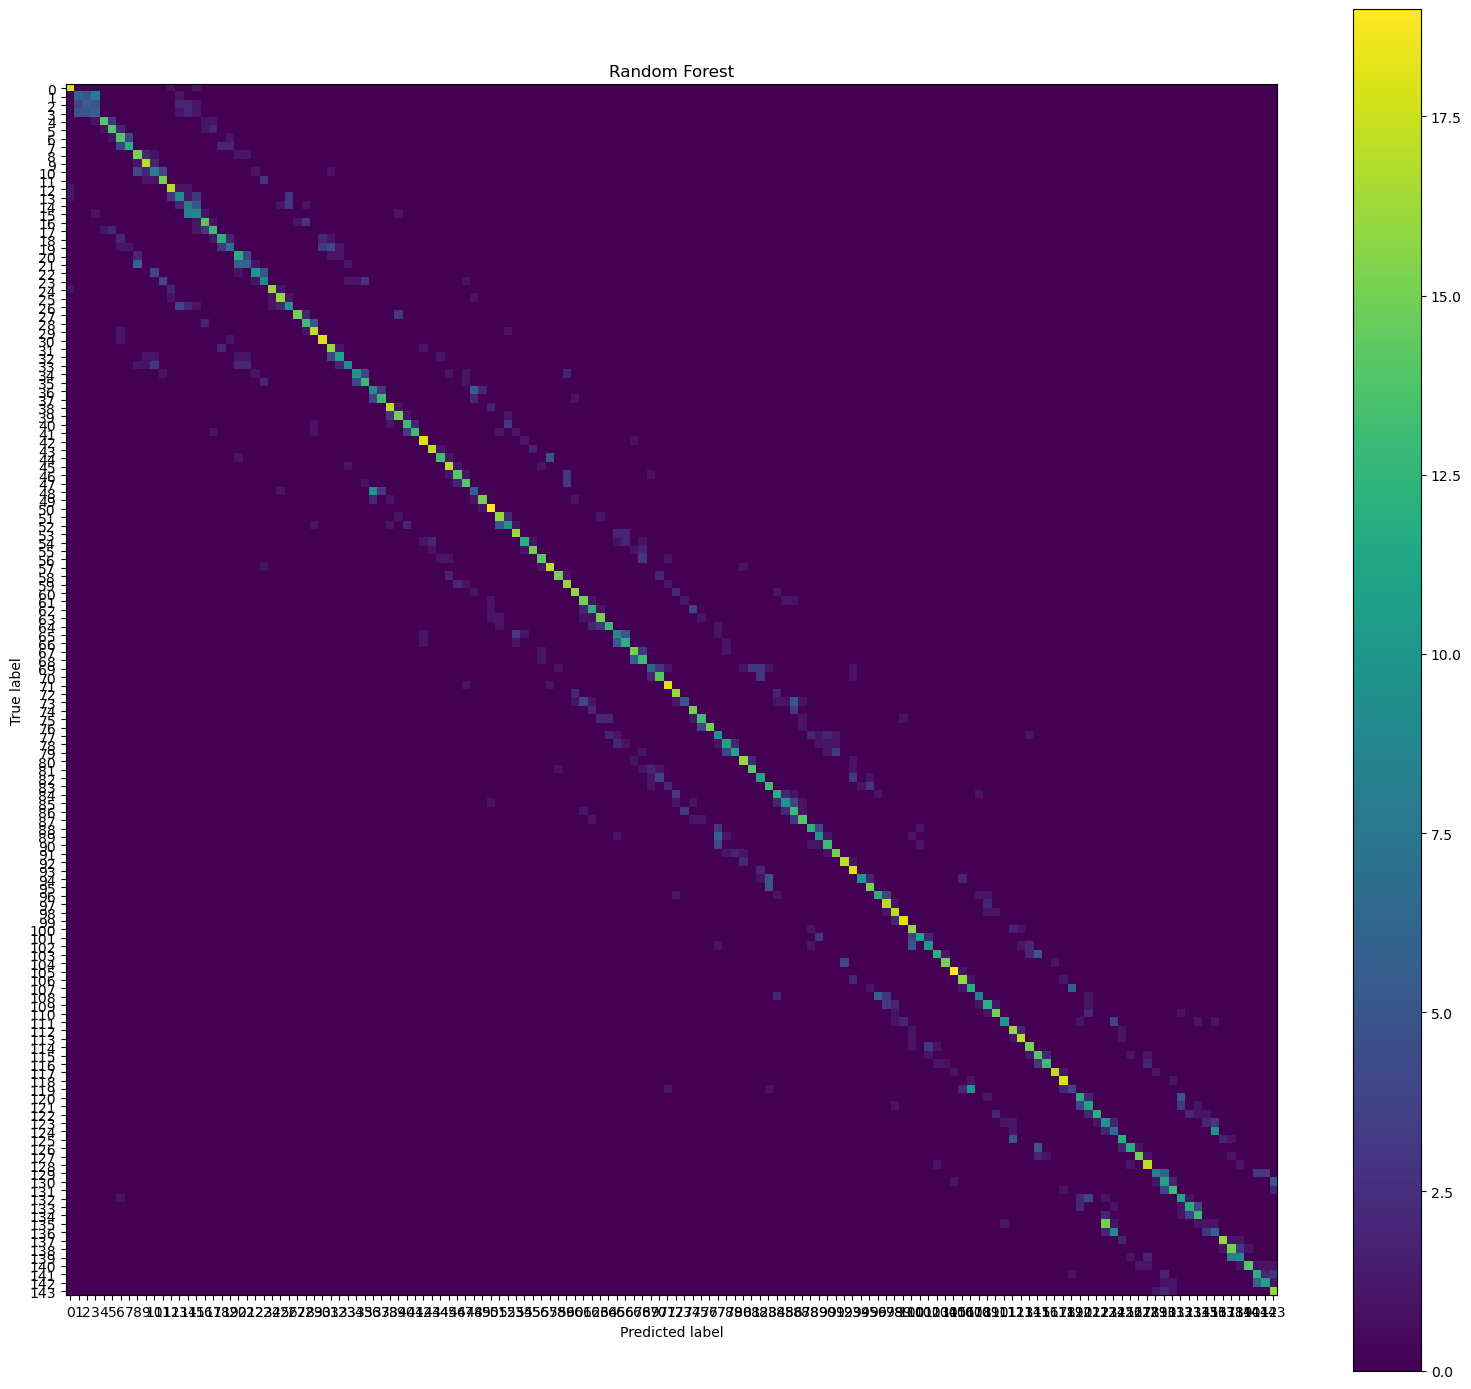


=== SVM (Linear) ===
Test accuracy: 69.17%
Cross-validated accuracy: 69.21% ± 0.46%


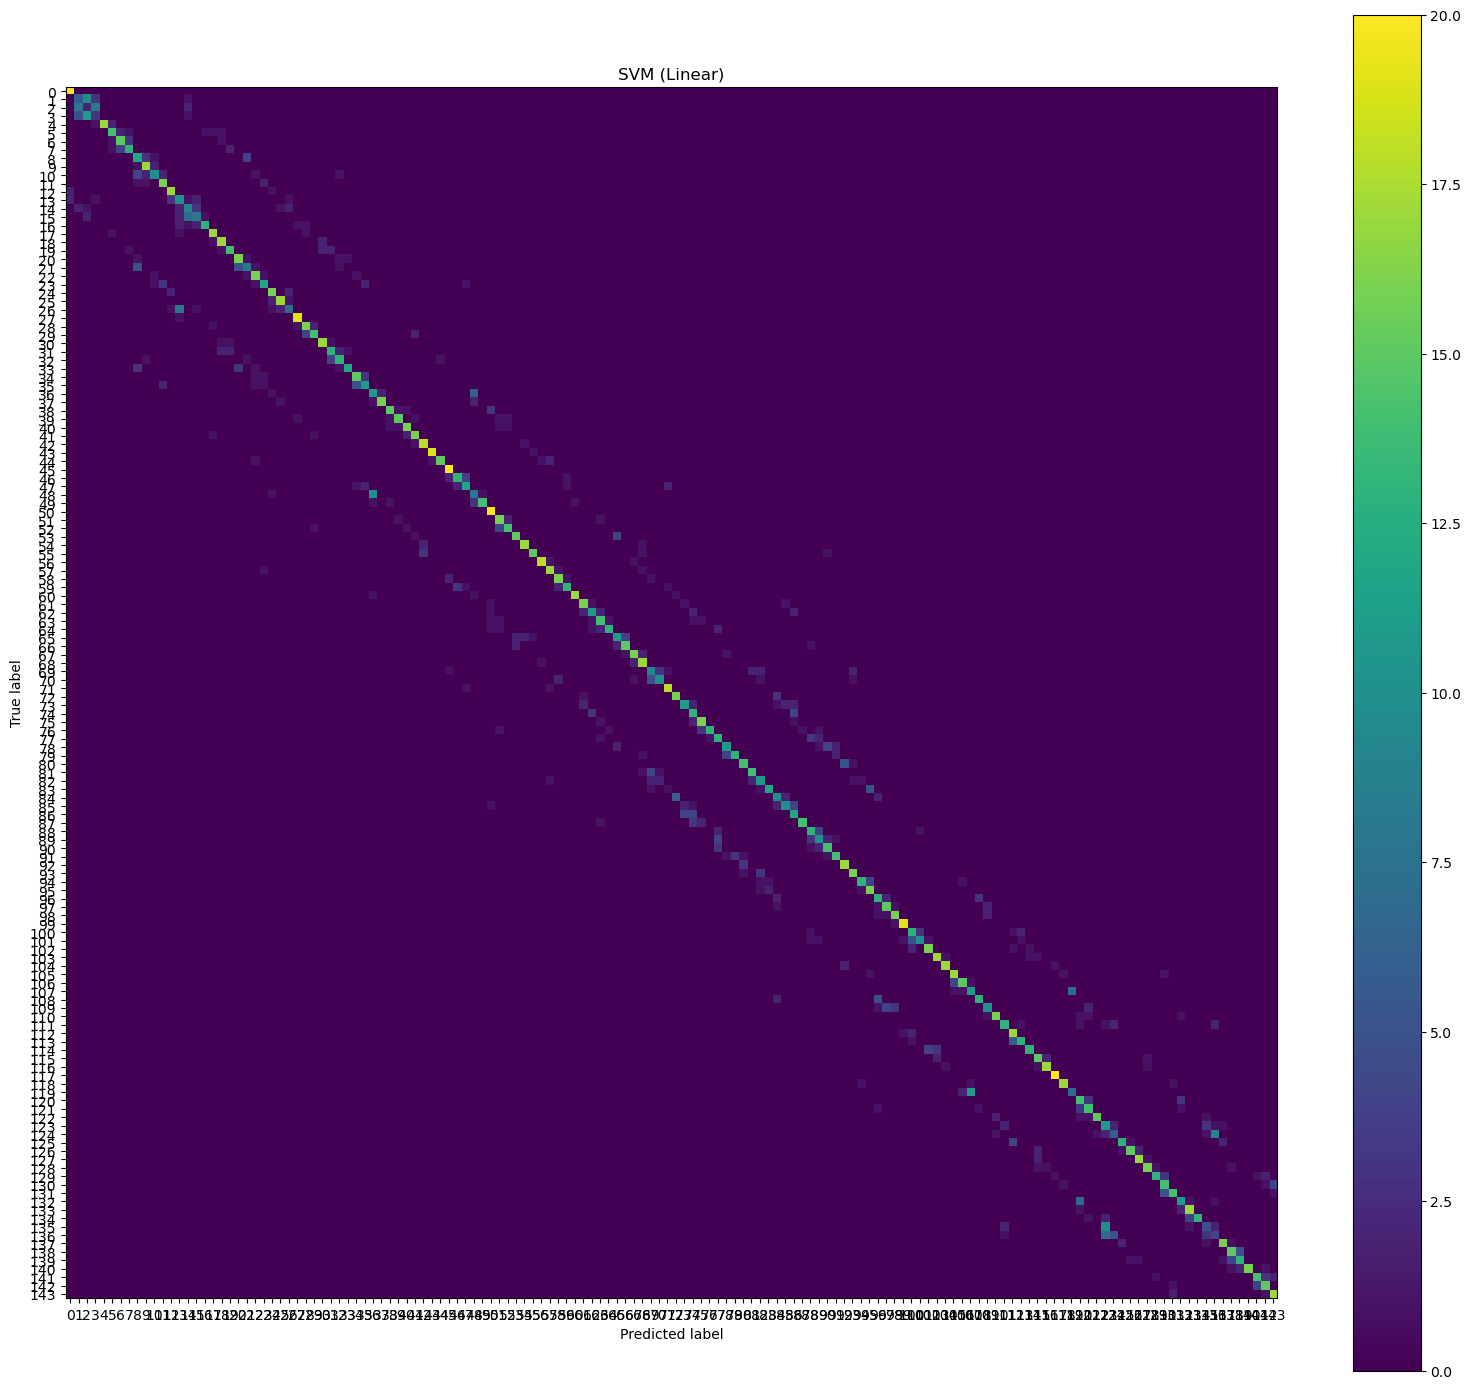


=== SVM (RBF) ===
Test accuracy: 72.67%
Cross-validated accuracy: 73.54% ± 0.54%


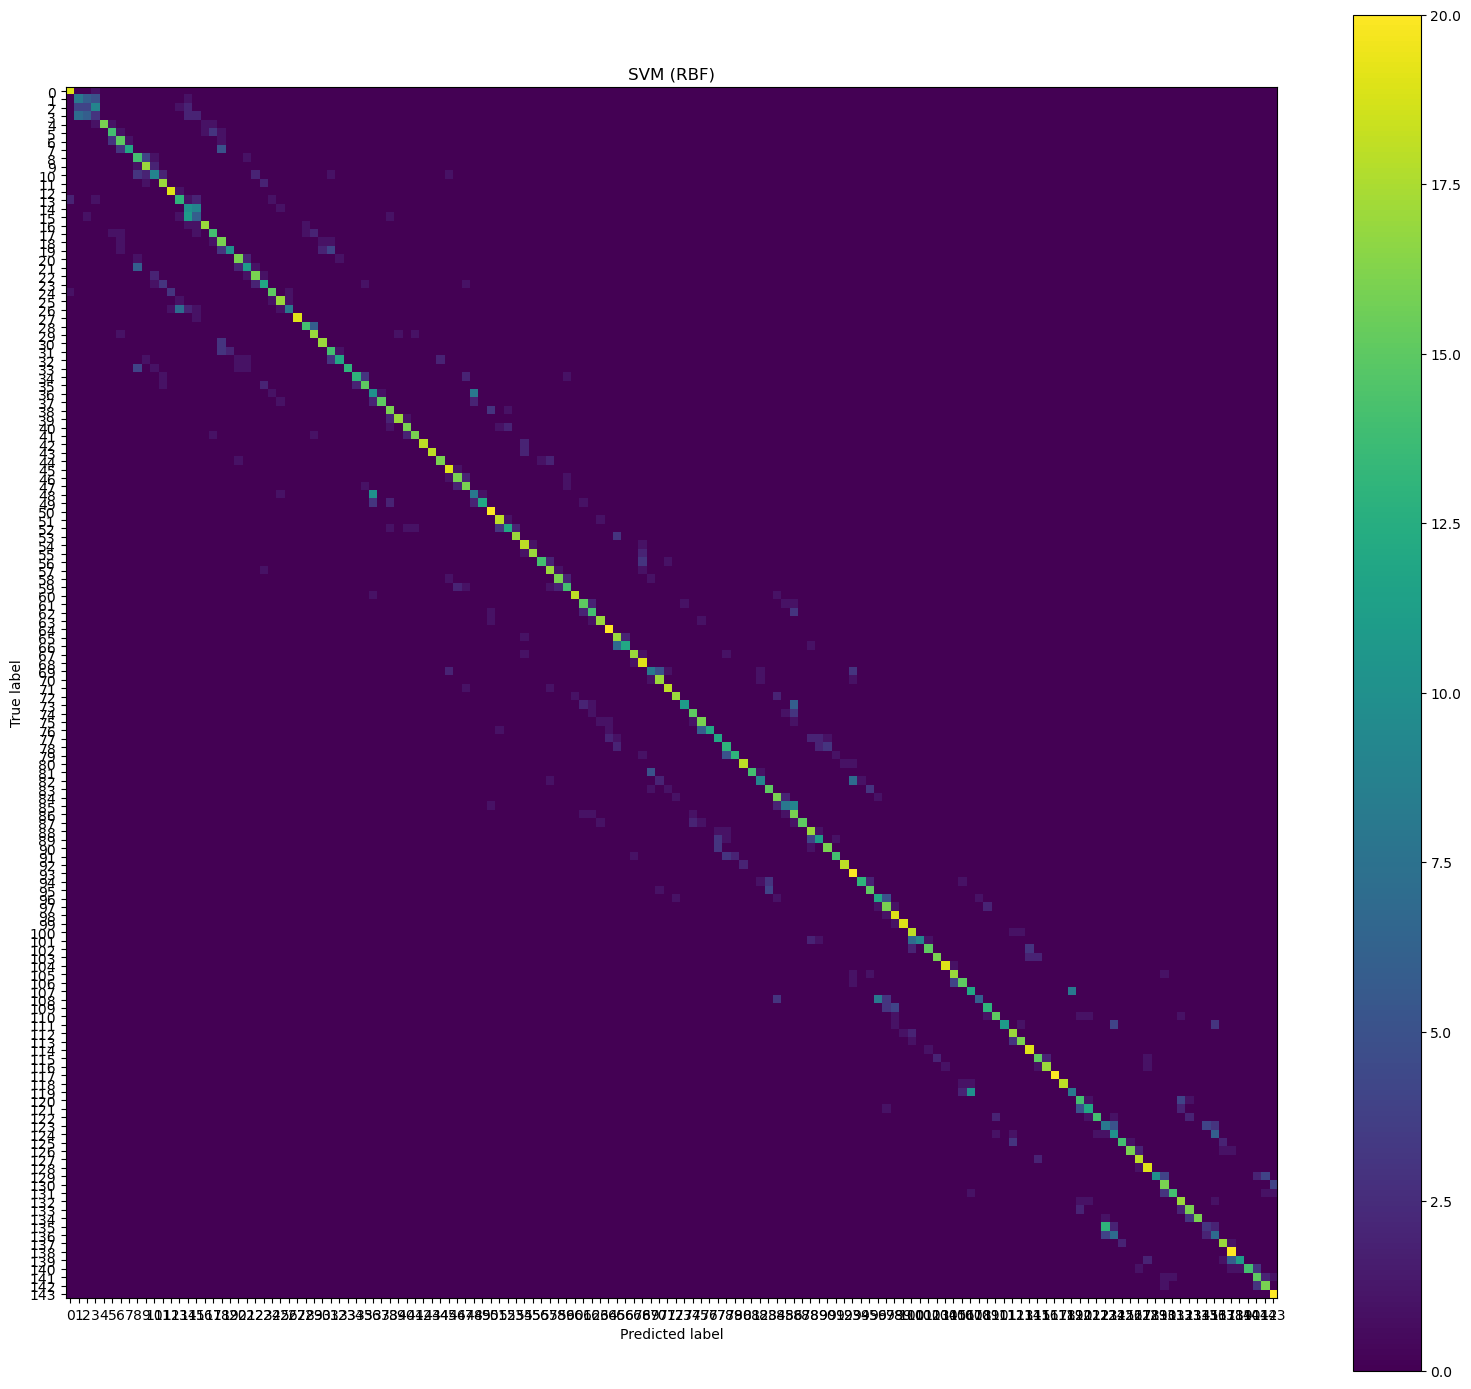


=== Naive Bayes ===
Test accuracy: 68.61%
Cross-validated accuracy: 69.10% ± 0.79%


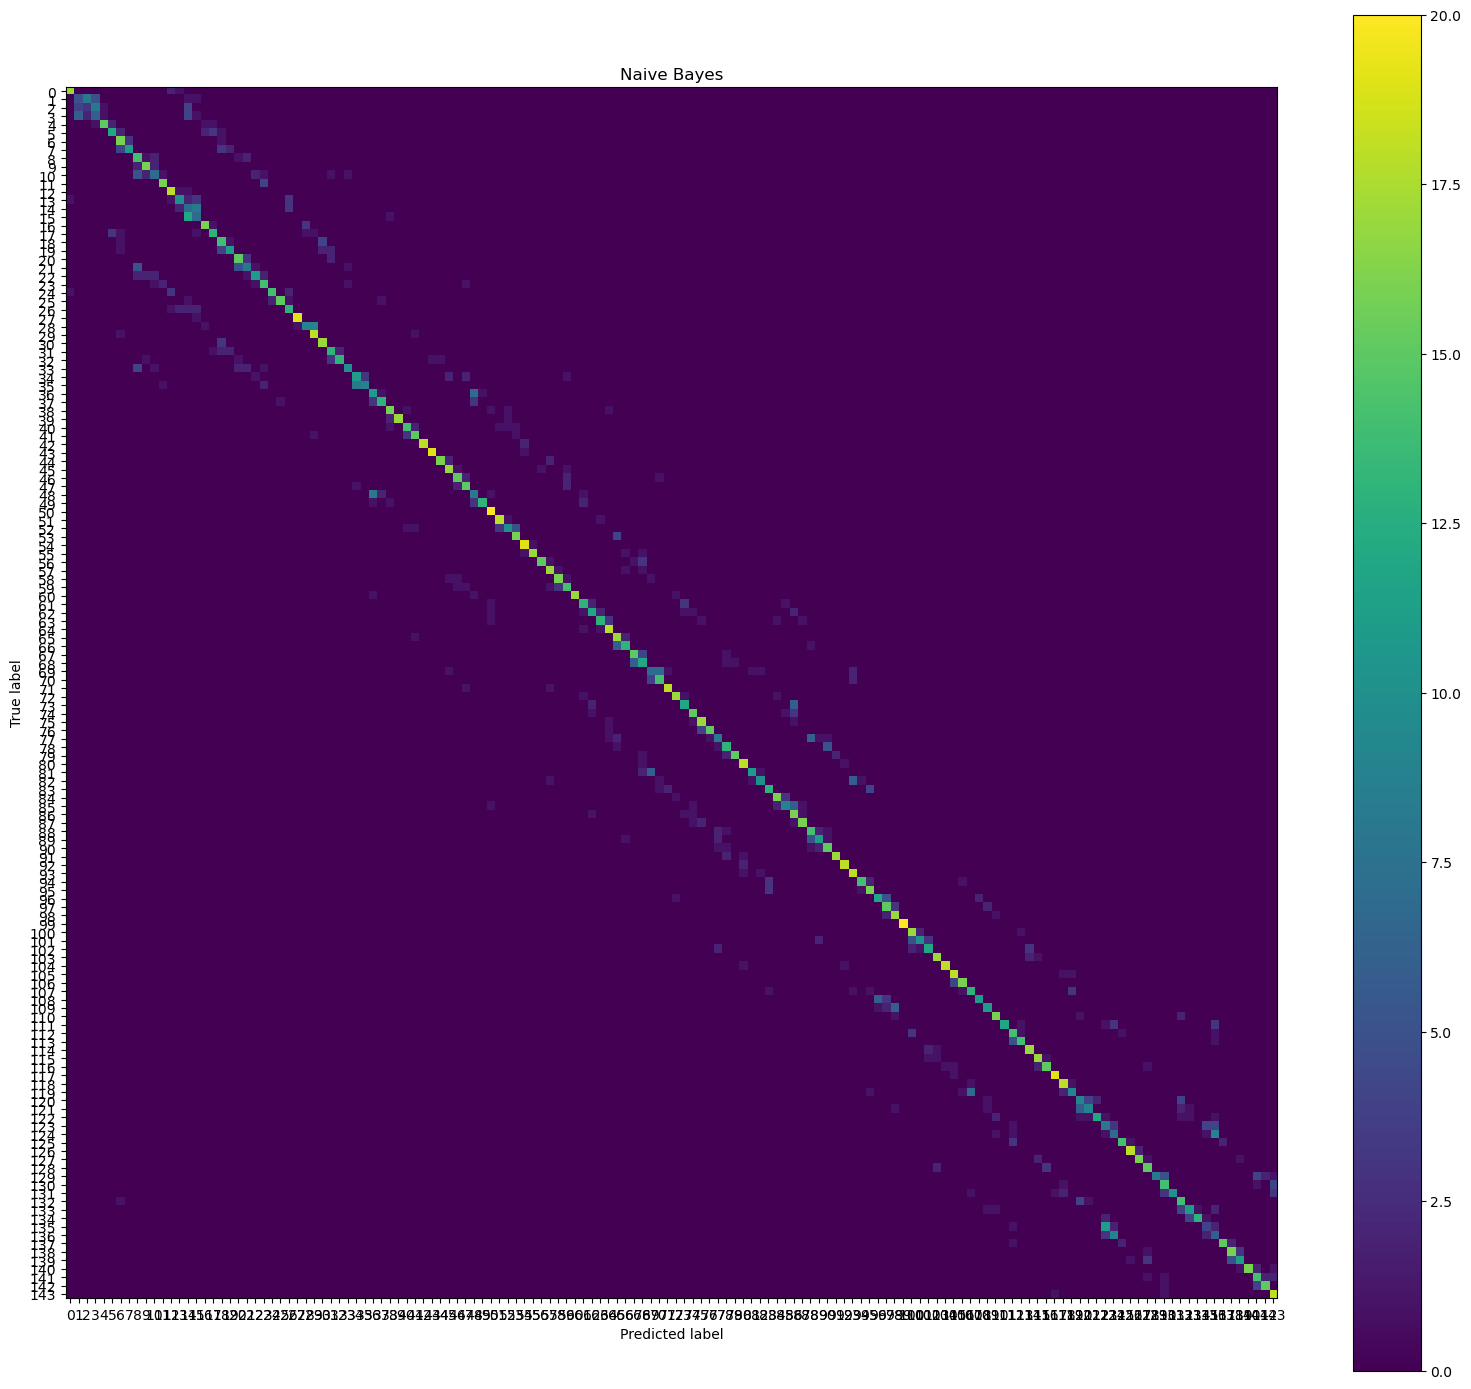


=== MLP ===
Test accuracy: 67.74%
Cross-validated accuracy: 68.51% ± 0.44%


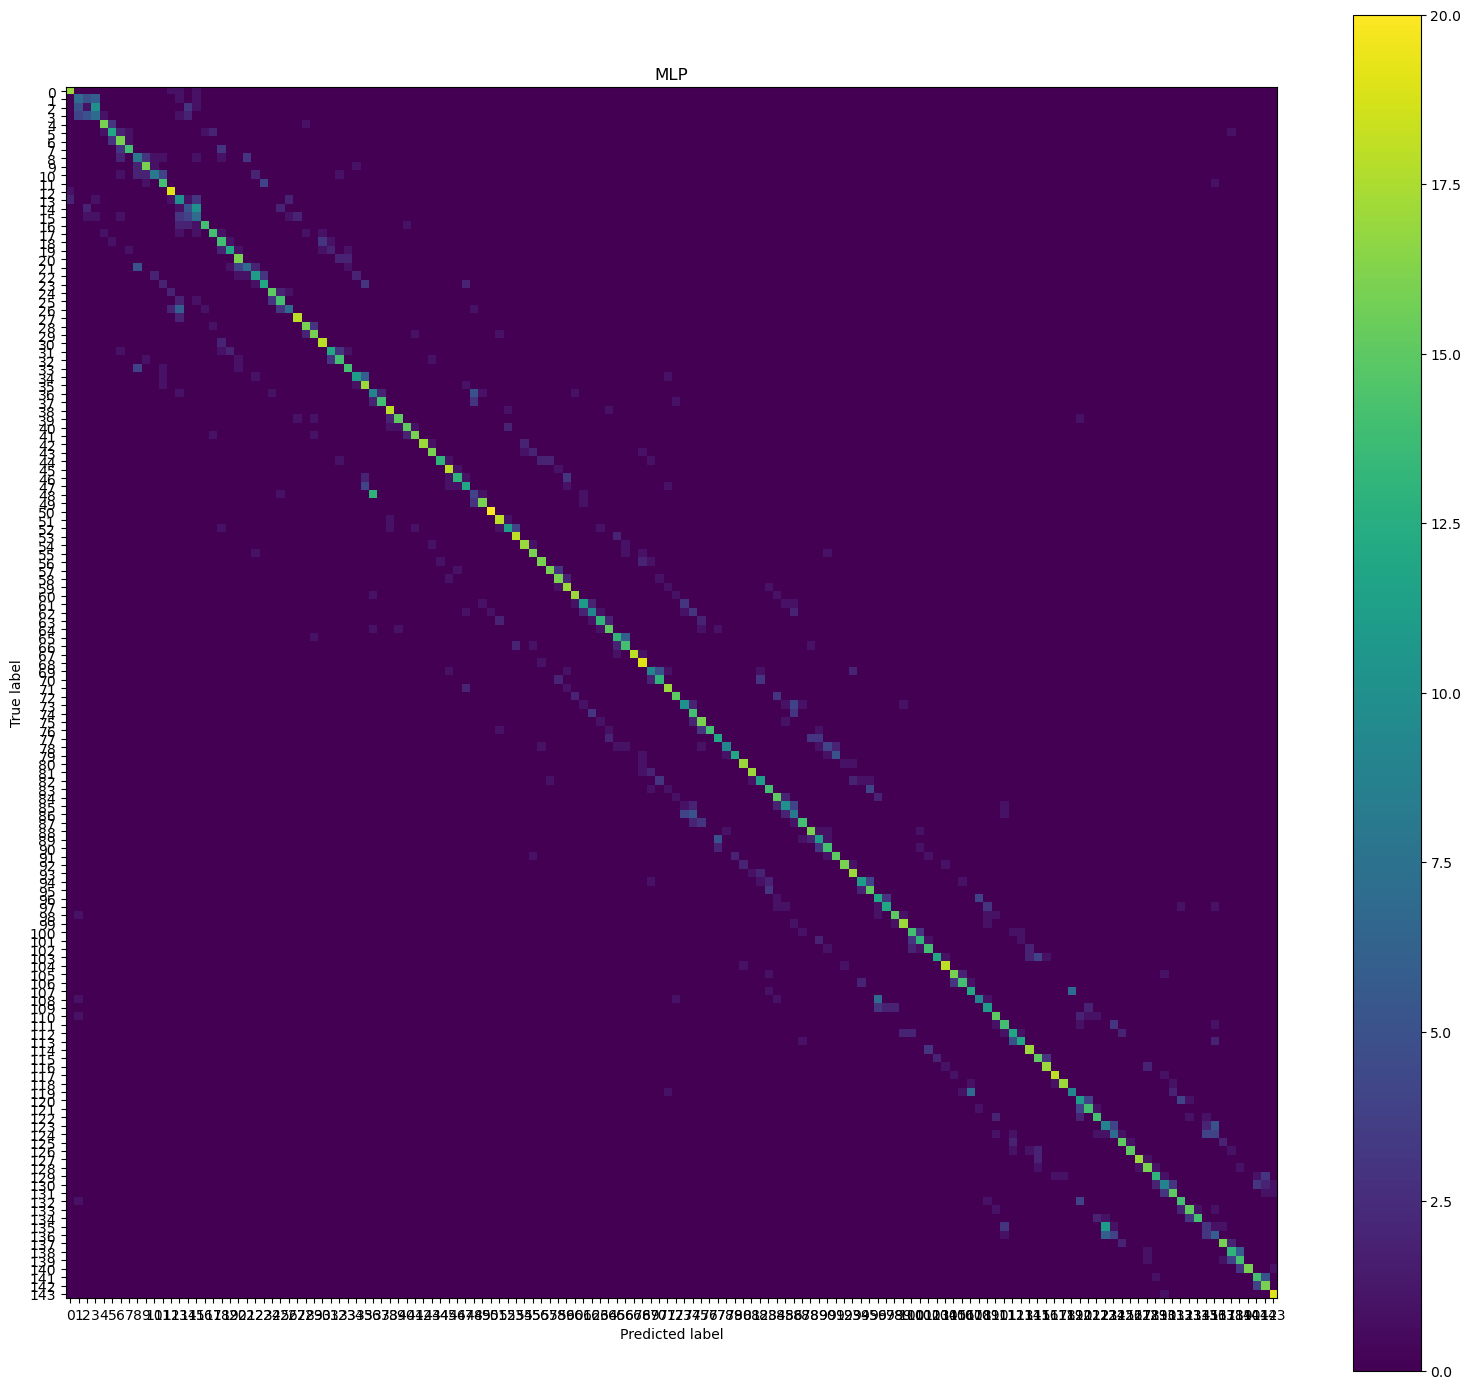

In [ ]:
num_trials, n_spots, n_neurons = spike_trains.shape

X = spike_trains.reshape(-1, n_neurons)
y = np.tile(np.arange(n_spots), num_trials)
results = compare_classifiers(X, y, pca_components=0.95)